In [6]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

Cloning into 'DenseDepth'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 324 (delta 10), reused 22 (delta 9), pack-reused 298
Receiving objects: 100% (324/324), 12.59 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (160/160), done.
--2023-11-27 09:17:10--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.92.16.160, 52.92.17.136, 52.218.117.112, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.92.16.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth/nyu.h5’

./DenseDepth/nyu.h5 100%[===================>] 164.89M  29.1MB/s    in 6.5s    

2023-11-27 09:17:17 (25.2 MB/s) - ‘./DenseDepth/nyu.h5’ saved [172897376/172897376]



In [1]:
import os
import sys
import numpy as np
import cv2
import time
import subprocess
from PIL import Image
import platform

from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [2]:
# Load model

model_file = 'nyu.h5'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

model = load_model(model_file, custom_objects=custom_objects, compile=False)
print("Model loaded")

Model loaded


In [3]:
def getDepthMap(image_path, model):
    start_time = time.time()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_height = image.shape[0]
    orig_width = image.shape[1]
    resized_image = cv2.resize(image, dsize=(640, 480), interpolation=cv2.INTER_AREA)
    input = np.clip(np.asarray(resized_image, dtype=float) / 255, 0, 1)

    output = predict(model, input)

    output_resized = cv2.resize(output[0], (orig_width, orig_height), interpolation=cv2.INTER_CUBIC)
    output_rescaled = cv2.normalize(output_resized, None, 0, 255, cv2.NORM_MINMAX)
    new_pathname = image_path.replace('.', '_depthmap.')
    cv2.imwrite(new_pathname, output_rescaled)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display first image on the first axis
    axs[0].imshow(image)
    axs[0].set_title('Original image')

    # Display the second image (array) on the second axis
    axs[1].imshow(output_rescaled, cmap='gray')  # Use cmap='gray' for grayscale images
    axs[1].set_title('Depth Map')

    # Hide axis ticks and labels
    for ax in axs:
        ax.axis('off')

    # Show the images side by side
    plt.tight_layout()
    plt.show()

    end_time = time.time()
    print(f'\nDepthmap predicted. Time taken: {end_time - start_time:.2f} seconds.')
    return output_rescaled


In [4]:
def load_image_jpg(image_name):
    image = Image.open(image_name)
    pixels = image.load()
    width, height = image.size
    print(f"width: {width} | height: {height}")
    image_array = np.array([[pixels[x, y] for y in range(image.height)] for x in range(image.width)])
    return image_array, width, height



def load_image_png(image_name):
    image = Image.open(image_name)
    pixels = image.load()
    width, height = image.size
    print(f"width: {width} | height: {height}")
    new_array = []
    for x in range(width):
        # print(f"ROW: {x}")
        row = []
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = pixels[x, y]
            row.append((pixel[0], pixel[1], pixel[2]))
        new_array.append(row)
    new_array = np.array(new_array)
    return new_array, width, height


def load_depthmap_png(image_name):
    image = Image.open(image_name)
    pixels = image.load()
    width, height = image.size
    print(f"width: {width} | height: {height}")
    new_array = []
    for x in range(width):
        # print(f"ROW: {x}")
        row = []
        for y in range(height):
            # Get the RGB values of the pixel
            a = pixels[x, y]
            row.append((a, a, a))
        new_array.append(row)
    new_array = np.array(new_array)
    return new_array, width, height


def initialize_arrays(width, height):
    # Initialize image array
    image_array = np.zeros((width, height, 3), dtype=np.uint8)

    # Initialize depth map array
    depth_map_array = np.zeros((width, height, 3), dtype=np.uint8)

    # Initialize point tuple
    point = (10, 20)

    return image_array, depth_map_array, point


def parse_output_file(filename, width, height):
    image_array = [[(0, 0, 0) for _ in range(height)] for _ in range(width)]

    array = []
    with open(filename, 'r') as file:
        array.append(file.readline().rstrip())
    new_array = array[0].split(" ")
    new_array = list(map(int, new_array))
    return new_array


def long_array_to_3d(long_array, width, height):
    rgb_values = []
    for x in range(width):
        for y in range(height):
            index = (x * height * 3) + y * 3
            rgb_values.append((long_array[index], long_array[index + 1], long_array[index + 2]))
    image = []
    for i in range(width):
        row = []
        for j in range(height):
            row.append(rgb_values[i * height + j])
        image.append(row)
    return image


def create_image(rgb_image, width, height):
    # Create a new image
    new_image = Image.new("RGB", (width, height))

    # Load pixel data
    pixels = new_image.load()

    # Assign the RGB values to the image pixels
    for x in range(width):
        for y in range(height):
            pixels[x, y] = rgb_image[x][y]

    # Save the image
    new_image.save(f"images_result/bokeh_fast_output.jpg")


def bokeh(focus_point, image_name, depthmap_name):
    image = image_name
    depth_map = depthmap_name

    print("loading normal image")
    # input_image, image_width, image_height = load_image_jpg(image)
    input_image, image_width, image_height = load_image_png(image)
    print("loading depth map")
    # input_depth_map, _, _ = load_image_jpg(depth_map)
    input_depth_map, _, _ = load_depthmap_png(depth_map)

    # Flatten arrays for passing as command line arguments
    image_array_str = " ".join(map(str, input_image.flatten()))
    depth_map_array_str = " ".join(map(str, input_depth_map.flatten()))

    with open("image_array.txt", 'w') as file:
        file.write(image_array_str + "\n")

    with open("depth_array.txt", 'w') as file2:
        file2.write(depth_map_array_str + "\n")

    focus_depth = input_depth_map[focus_point[0]][focus_point[1]][0]
    max_depth_diff = 10.0
    coc_scale = 100

    print("running bokeh")
    # Call the compiled C++ program with the parameters
    print(str(image_width), str(image_height), str(focus_depth), str(max_depth_diff), str(coc_scale))
    
    # Run the command and set the working directory
    bokeh_executable = ".\\bokeh_fast.exe" if platform.system() == "Windows" else "./bokeh_fast"
    subprocess.run([bokeh_executable, str(image_width), str(image_height), str(focus_depth), str(max_depth_diff), str(coc_scale)], check=True)
    print("writing to file")
    output_array = parse_output_file("output.txt", image_width, image_height)
    output_img = long_array_to_3d(output_array, image_width, image_height)
    create_image(output_img, image_width, image_height)
    return np.array(output_img).astype(np.uint8)



In [5]:
def getPointCorrespondences(imagePath, depthmap):
    global point
    point = (-1, -1)
    point_click = (-1, -1)
    point_list = []
    im1 = cv2.imread(imagePath)
    height, width, _ = im1.shape
    cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback('Image', get_coords)
    cv2.imshow('Image', im1)

    while True:
        
        k = cv2.waitKey(20) & 0xFF

        if point_click != point:
            cv2.circle(im1, point, 2, (0, 0, 255), 2)
            point_click = point
            point_list.append(point_click)
            
            # insert code
            new_imag = bokeh(point_click, imagePath, depthmap)
            new_imag_bgr = cv2.cvtColor(new_imag, cv2.COLOR_RGB2BGR)
            new_imag_rotated = cv2.rotate(new_imag_bgr, cv2.ROTATE_90_CLOCKWISE)
            flipped_image = cv2.flip(new_imag_rotated, 1)
            cv2.imshow('Image', flipped_image)

        if k == 27:
            break

        # S: return list of points
        elif k == ord('s'):
            count = countx = county = 0
            pointx = pointy = np.zeros(( (len(point_list)+1)//2, 2)) # [num_points, 2]
            for p in point_list:
                # image 1
                if count % 2 == 0:
                    pointx[countx] = [p[0], p[1]]
                    countx += 1
            return pointx, pointy

    cv2.destroyAllWindows()
    return point_list


def get_coords(event, x, y, flags, param):
    global point
    if event == cv2.EVENT_LBUTTONDOWN:
        point = x, y
        print(point)

In [6]:
def clickDepth(imagePath, depthmap):
    getPointCorrespondences(imagePath, depthmap)

1/1 [==============================] - 2s 2s/step


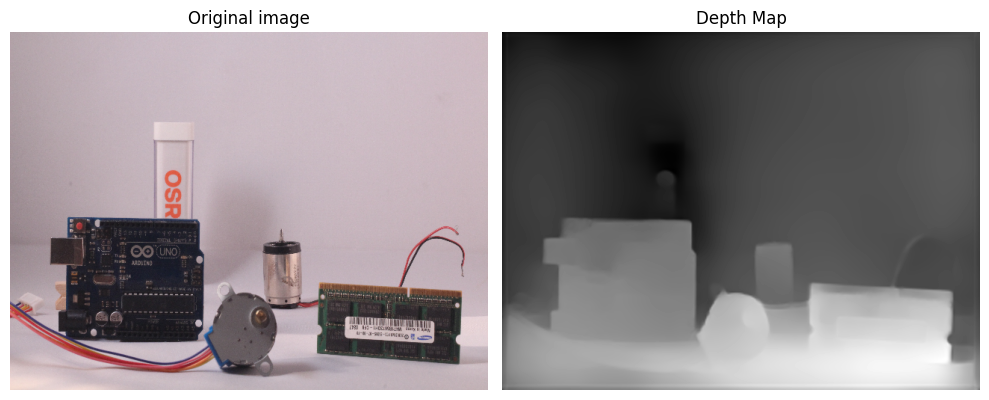


Depthmap predicted. Time taken: 2.77 seconds.
(207, 312)
loading normal image
width: 640 | height: 480
loading depth map
width: 640 | height: 480
running bokeh
640 480 123 10.0 100
writing to file
(519, 401)
loading normal image
width: 640 | height: 480
loading depth map
width: 640 | height: 480
running bokeh
640 480 213 10.0 100
writing to file
(296, 413)
loading normal image
width: 640 | height: 480
loading depth map
width: 640 | height: 480
running bokeh
640 480 192 10.0 100
writing to file


In [9]:
imagePath = "examples/test_image.png"
getDepthMap(imagePath, model)
depthMapPath = imagePath.replace('.', '_depthmap.')
clickDepth(imagePath, depthMapPath)